# Chapter 3

This notebook contains the commands that are shown in the lecture 3.

In [3]:
library(tidyverse)
library(lubridate)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



## Grouping data by a common variable

### Description of data - Triton cluster file statistics

[read_table2](https://readr.tidyverse.org/reference/read_table.html)

In [4]:
load_filesizes <- function(filesizes_file){
    filesizes <- read_table2(filesizes_file, col_names=c('Bytes','MonthsTo2021', 'Files'))
    
    filesizes <- filesizes %>%
        # Remove empty files
        filter(Bytes != 0) %>%
        # Create a column for log2 of bytes
        mutate(BytesLog2 = log2(Bytes)) %>%
        # Determine total space S used by N files of size X during date D: S=N*X 
        mutate(SpaceUsage = Bytes*Files) %>%
        # Determine file year and month from the MonthsTo2021-column
        mutate(
            TotalMonths = 2021*12 - MonthsTo2021 - 1,
            Year = TotalMonths %/% 12,
            Month = TotalMonths %% 12 +1,
            Day = 1
        )

     # Set year for really old files and files with incorrect timestamps
    invalid_years = c((filesizes['Year'] < 2010) | (filesizes['Year'] > 2020))
    filesizes[invalid_years, c('Year','Month')] <- NaN
    
    # Get month names for the correct ordering of Month categories
    month_names <- month(seq(1,12), label=TRUE, locale='C')
    filesizes <- filesizes %>%
        mutate(
            # Create Date and get the name for the month
            Date = make_datetime(Year, Month, Day),
            # Set Month 
            Month=month(Month, label=TRUE, locale='C'),
            # Set Month to be an ordered categorical with predefined levels 
            Month=factor(Month, ordered=TRUE, levels=month_names))
    filesizes <- filesizes %>%
        # Sort data based on Date and BytesLog2
        arrange(Date, BytesLog2) %>%
        # Remove old columns
        select(-MonthsTo2021,-TotalMonths,-Day)
    return(filesizes)
}

filesizes <- load_filesizes('../data/filesizes_timestamps.txt')
head(filesizes)

Parsed with column specification:
cols(
  Bytes = col_double(),
  MonthsTo2021 = col_double(),
  Files = col_double()
)


Bytes,Files,BytesLog2,SpaceUsage,Year,Month,Date
1,5,0,5,2010,Jan,2010-01-01
2,3,1,6,2010,Jan,2010-01-01
4,27,2,108,2010,Jan,2010-01-01
8,136,3,1088,2010,Jan,2010-01-01
16,208,4,3328,2010,Jan,2010-01-01
32,653,5,20896,2010,Jan,2010-01-01


### Simple groupings and summaries - Calculating new files per year

In [5]:
newfiles_relevant <- filesizes %>%
    # Drop rows with NaNs (invalid years)
    drop_na() %>%
    # Pick relevant columns
    select(Year, Files) %>%
    # Change year to category for prettier plotting
    mutate(Year=as.factor(Year))
head(newfiles_relevant)

Year,Files
2010,5
2010,3
2010,27
2010,136
2010,208
2010,653


In [6]:
glimpse(newfiles_relevant)

newfiles_yearly_sum <- newfiles_relevant %>%
    group_by(Year) %>%
    summarize(Files=sum(Files))

glimpse(newfiles_yearly_sum)
head(newfiles_yearly_sum)

Observations: 4,698
Variables: 2
$ Year  <fct> 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 201…
$ Files <dbl> 5, 3, 27, 136, 208, 653, 934, 824, 1679, 2151, 3056, 4642, 3649…
Observations: 11
Variables: 2
$ Year  <fct> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
$ Files <dbl> 5590287, 13197038, 17099900, 14755151, 26329321, 24896331, 4368…


Year,Files
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321
2015,24896331


In [7]:
newfiles_yearly_sum <- newfiles_yearly_sum %>%
    ungroup()

head(newfiles_yearly_sum)

Year,Files
2010,5590287
2011,13197038
2012,17099900
2013,14755151
2014,26329321
2015,24896331


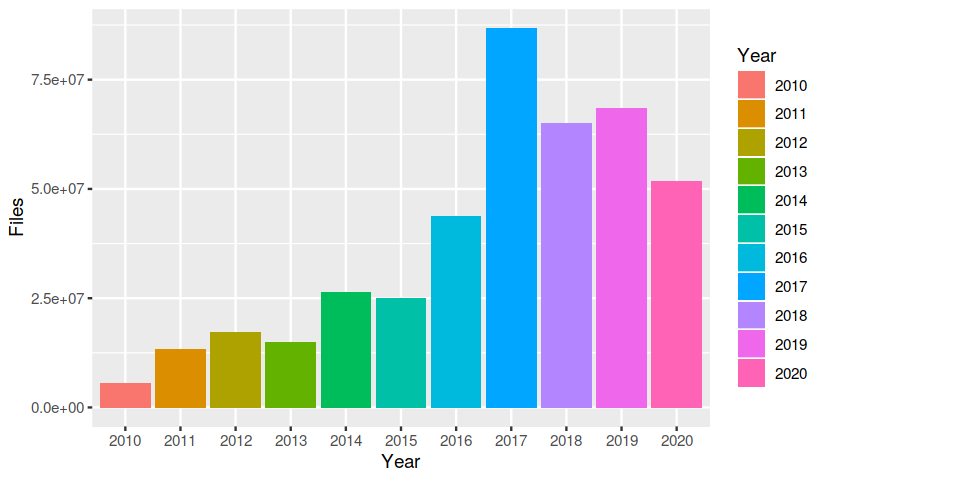

In [8]:
options(repr.plot.width=8, repr.plot.height=4)

newfiles_yearly_sum %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col()

### Creating a function for many different summaries

In [9]:
aggregate_filesize_data <- function(data, grouping, target, agg_function) {
    data_relevant <- data %>%
        # Drop rows with NaNs (invalid years)
        drop_na() %>%
        # Pick relevant columns
        select_at(vars(c(grouping, target))) %>%
        # Change grouping to category for prettier plotting
        mutate_at(vars(grouping), as.factor)

    # Aggregate data
    data_aggregated <- data_relevant %>%
        group_by_at((grouping)) %>%
        summarize_at(vars(target), agg_function) %>%
        ungroup()

    return(data_aggregated)
}

Year,Files,SpaceUsage
2010,5590287,"2,260716e+12"
2011,13197038,"7,000732e+12"
2012,17099900,"1,547558e+13"
2013,14755151,"1,544538e+13"
2014,26329321,"4,253036e+13"
2015,24896331,"3,096538e+13"


Month,Files,SpaceUsage
Jan,34921070,"4,313122e+13"
Feb,35707864,"7,102250e+13"
Mar,25494722,"5,651687e+13"
Apr,31224476,"7,538209e+13"
May,37816173,"7,533862e+13"
Jun,33804495,"7,010947e+13"


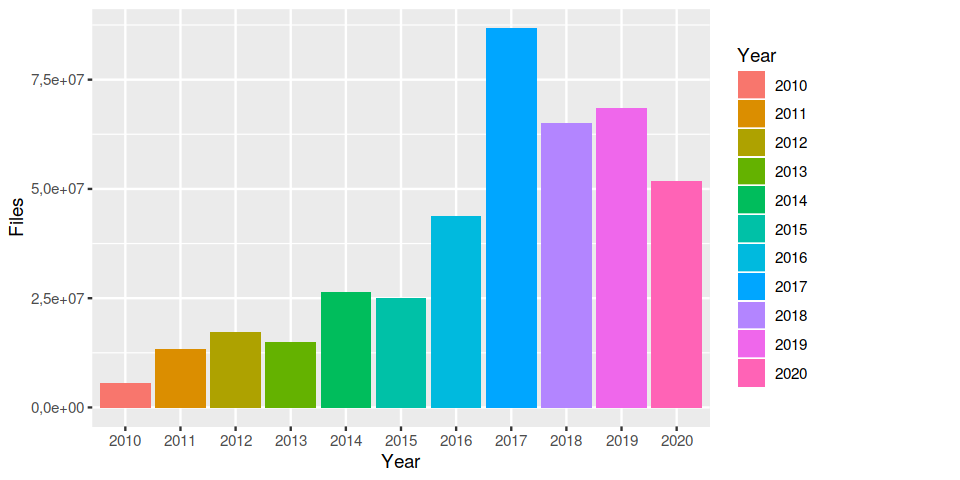

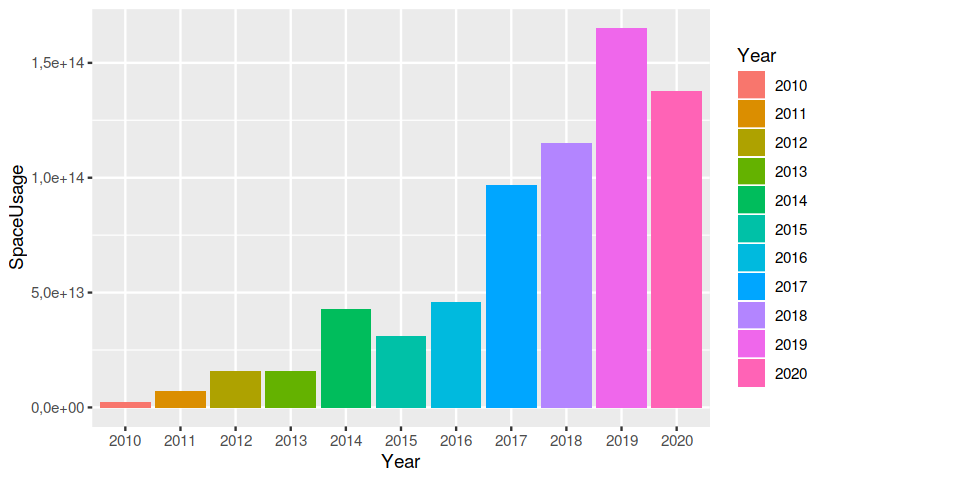

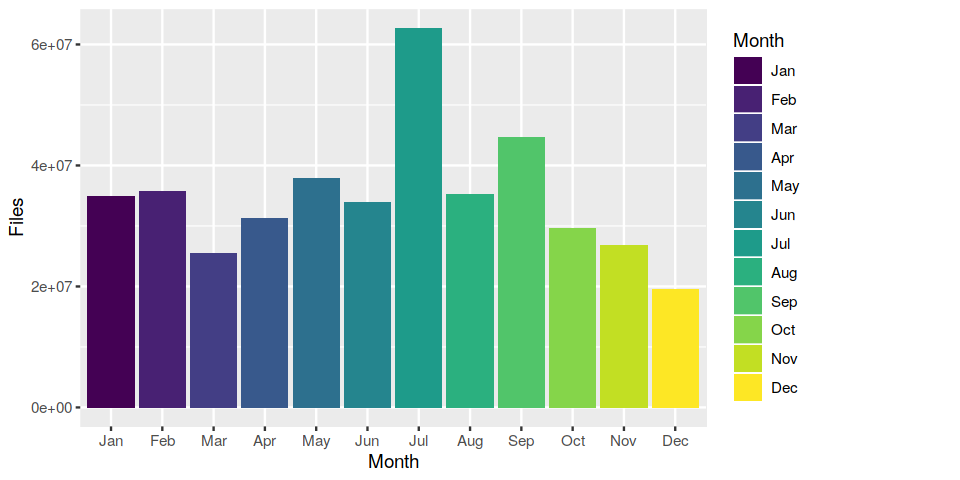

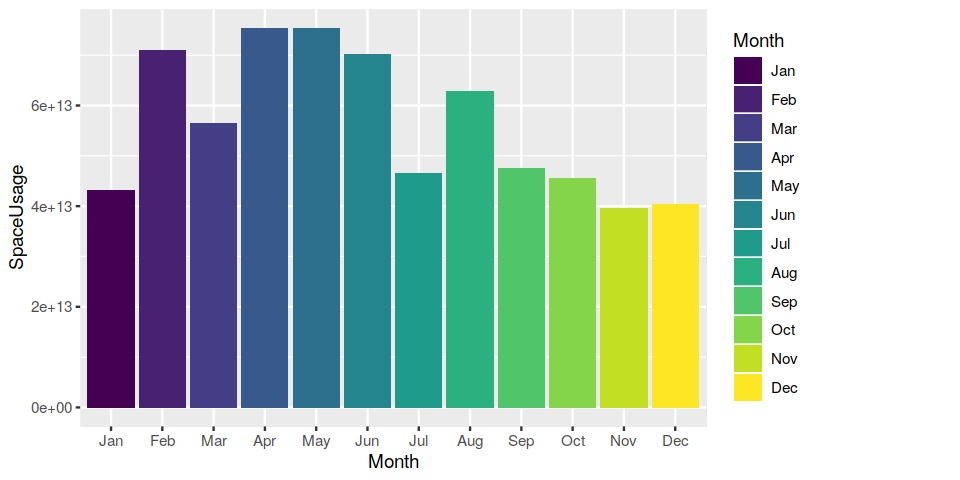

In [10]:
yearly_sum <- aggregate_filesize_data(filesizes, c('Year'), c('Files', 'SpaceUsage'), sum)
monthly_sum <- aggregate_filesize_data(filesizes, c('Month'), c('Files', 'SpaceUsage'), sum)

head(yearly_sum)
head(monthly_sum)

print(yearly_sum %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col())
print(yearly_sum %>%
    ggplot(aes(x=Year, y=SpaceUsage, fill=Year)) +
    geom_col())
print(monthly_sum %>%
    ggplot(aes(x=Month, y=Files, fill=Month)) +
    geom_col())
print(monthly_sum %>%
    ggplot(aes(x=Month, y=SpaceUsage, fill=Month)) +
    geom_col())

## Using bootstrapping/resampling methods for the calculation of statistical moments

### Quick overview of bootstrapping

In [11]:
newfiles_relevant2 <- filesizes %>%
    # Drop rows with NaNs (invalid years)
    drop_na() %>%
    # Pick relevant columns
    select(Year, BytesLog2, Files) %>%
    # Aggregate based on Year and BytesLog2
    group_by(Year, BytesLog2) %>%
    summarize(Files=sum(Files))

head(newfiles_relevant2)

Year,BytesLog2,Files
2010,0,124
2010,1,1632
2010,2,5626
2010,3,26287
2010,4,65074
2010,5,202543


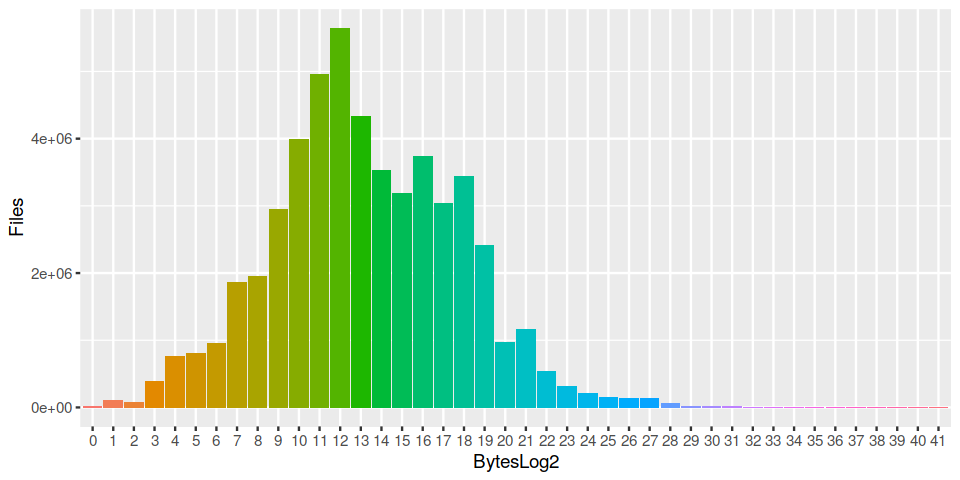

In [57]:
yearly_bytes_sum = aggregate_filesize_data(filesizes, c('Year','BytesLog2'), c('Files', 'SpaceUsage'), sum)

bytes_2020 <- yearly_bytes_sum %>%
    filter(Year == 2020)

bytes_2020 %>%
    ggplot(aes(x=BytesLog2, y=Files, fill=BytesLog2)) +
    geom_col() +
    theme(legend.position = "none")

In [80]:
# Pick target data column and convert it to integer
# IMPORTANT:
#    Do notice that we'll have to first convert our target
#    into characters as we do not want convert factor ENCODING,
#    but the actual decoded DATA
target_data <- as.numeric(as.character(bytes_2020[['BytesLog2']]))

# Pick weight data column
weight_data <- bytes_2020[['Files']]

# Normalize weight_data into probabilities
weight_data <- weight_data/sum(weight_data)

print(head(target_data))
print(head(weight_data))

 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
[26] 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
[1] 0 1 2 3 4 5
[1] 0,0003271367 0,0019404559 0,0014705603 0,0074056601 0,0145700668
[6] 0,0156263905


In [81]:
# Create means vector
means <- numeric(10)
for (i in seq(10)) {
    # Calculate resampled mean
    means[[i]] <- mean(sample(target_data, 100, replace=TRUE, prob=weight_data))
}
print(means)
print(paste0('Estimated sample mean: ', mean(means)))

 [1] 13,19 13,14 13,11 13,95 13,23 13,41 12,71 12,65 13,61 13,36
[1] "Estimated sample mean: 13,236"


In [94]:
get_bootstrapped_means <- function(dataset, target_col, weight_col, n_means=1000) {
    # Pick relevant columns
    # Pick target data column and convert it to integer
    target_data <- as.numeric(as.character(dataset[[target_col]]))
    # Pick weight data column
    weight_data <- dataset[[weight_col]]
    weight_data <- weight_data/sum(weight_data)

    # Create means vector
    means <- numeric(n_means)
    for (i in seq(n_means)) {
        # Calculate resampled mean
        means[[i]] <- mean(sample(target_data, 100, replace=TRUE, prob=weight_data))
    }
    return(means)
}

means <- get_bootstrapped_means(bytes_2020, 'BytesLog2', 'Files', n_means=1000)
print(head(means,10))
print(paste0('Estimated sample mean: ', mean(means)))

 [1] 13,09 12,99 13,10 13,76 13,62 13,24 14,01 13,20 13,69 13,20
[1] "Estimated sample mean: 13,24047"


In [90]:
mean(get_bootstrapped_means(bytes_2020, 'BytesLog2', 'Files', n_means=10000))

[1] 13,23037

### Using nested dataframes to help with bootstrapping

In [260]:
yearly_means <- tibble(Year=unique(as.numeric(as.character(yearly_bytes_sum[['Year']]))))
head(yearly_means)

Year
2010
2011
2012
2013
2014
2015


In [261]:
yearly_means <- yearly_means %>%
    mutate(Data=map(Year, function(year) yearly_bytes_sum[yearly_bytes_sum[['Year']] == year,]))

glimpse(yearly_means)

Observations: 11
Variables: 2
$ Year <dbl> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
$ Data <list> [<tbl_df[37 x 4]>, <tbl_df[37 x 4]>, <tbl_df[38 x 4]>, <tbl_df[…


In [262]:
yearly_means <- yearly_means %>%
    mutate(SampledMeans=map(Data, function(data) get_bootstrapped_means(data, 'BytesLog2', 'Files', n_means=100)))

glimpse(yearly_means)

Observations: 11
Variables: 3
$ Year         <dbl> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 20…
$ Data         <list> [<tbl_df[37 x 4]>, <tbl_df[37 x 4]>, <tbl_df[38 x 4]>, …
$ SampledMeans <list> [<12,59, 13,02, 13,05, 12,40, 13,57, 12,68, 13,42, 12,9…


In [263]:
yearly_means <- yearly_means %>%
    mutate(Means=map(SampledMeans, mean))

glimpse(yearly_means)

Observations: 11
Variables: 4
$ Year         <dbl> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 20…
$ Data         <list> [<tbl_df[37 x 4]>, <tbl_df[37 x 4]>, <tbl_df[38 x 4]>, …
$ SampledMeans <list> [<12,59, 13,02, 13,05, 12,40, 13,57, 12,68, 13,42, 12,9…
$ Means        <list> [12,9883, 14,0285, 10,5997, 13,3987, 14,0103, 11,7998, …


In [264]:
bootstrap_byteslog2_mean <- function(dataset, group_variable, target_variable, n_means=1000) {
    
    # Create dataframe for our means (notice the syntax for setting a column name from dynamic variable)
    means <- tibble(!! group_variable := unique(as.numeric(as.character(yearly_bytes_sum[[group_variable]]))))
    means <- means %>%
        mutate(
            # Get data from dataset based on our group variable
            Data=map(means[[group_variable]], function(x) dataset[dataset[[group_variable]] == x,]),
            # Get SampledMeans = get_bootstrapped_means(Data)
            SampledMeans=map(Data, function(data) get_bootstrapped_means(data, 'BytesLog2', 'Files', n_means=100)),
            # Get Mean = mean(SampledMeans)
            Means=map(SampledMeans, mean)
        ) %>%
        # Drop Data-column
        select(-Data)

    return(means)
}

bootstrapped_means = bootstrap_byteslog2_mean(yearly_bytes_sum, 'Year', 'Files', n_means=1000)
glimpse(bootstrapped_means)

Observations: 11
Variables: 3
$ Year         <dbl> 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 20…
$ SampledMeans <list> [<13,06, 13,10, 13,12, 12,75, 13,02, 12,42, 12,52, 13,0…
$ Means        <list> [12,9681, 14,0316, 10,5862, 13,4107, 14,0485, 11,7422, …


In [265]:
bootstrapped_means_distribution <- bootstrapped_means %>%
    select(-Means) %>%
    unnest()

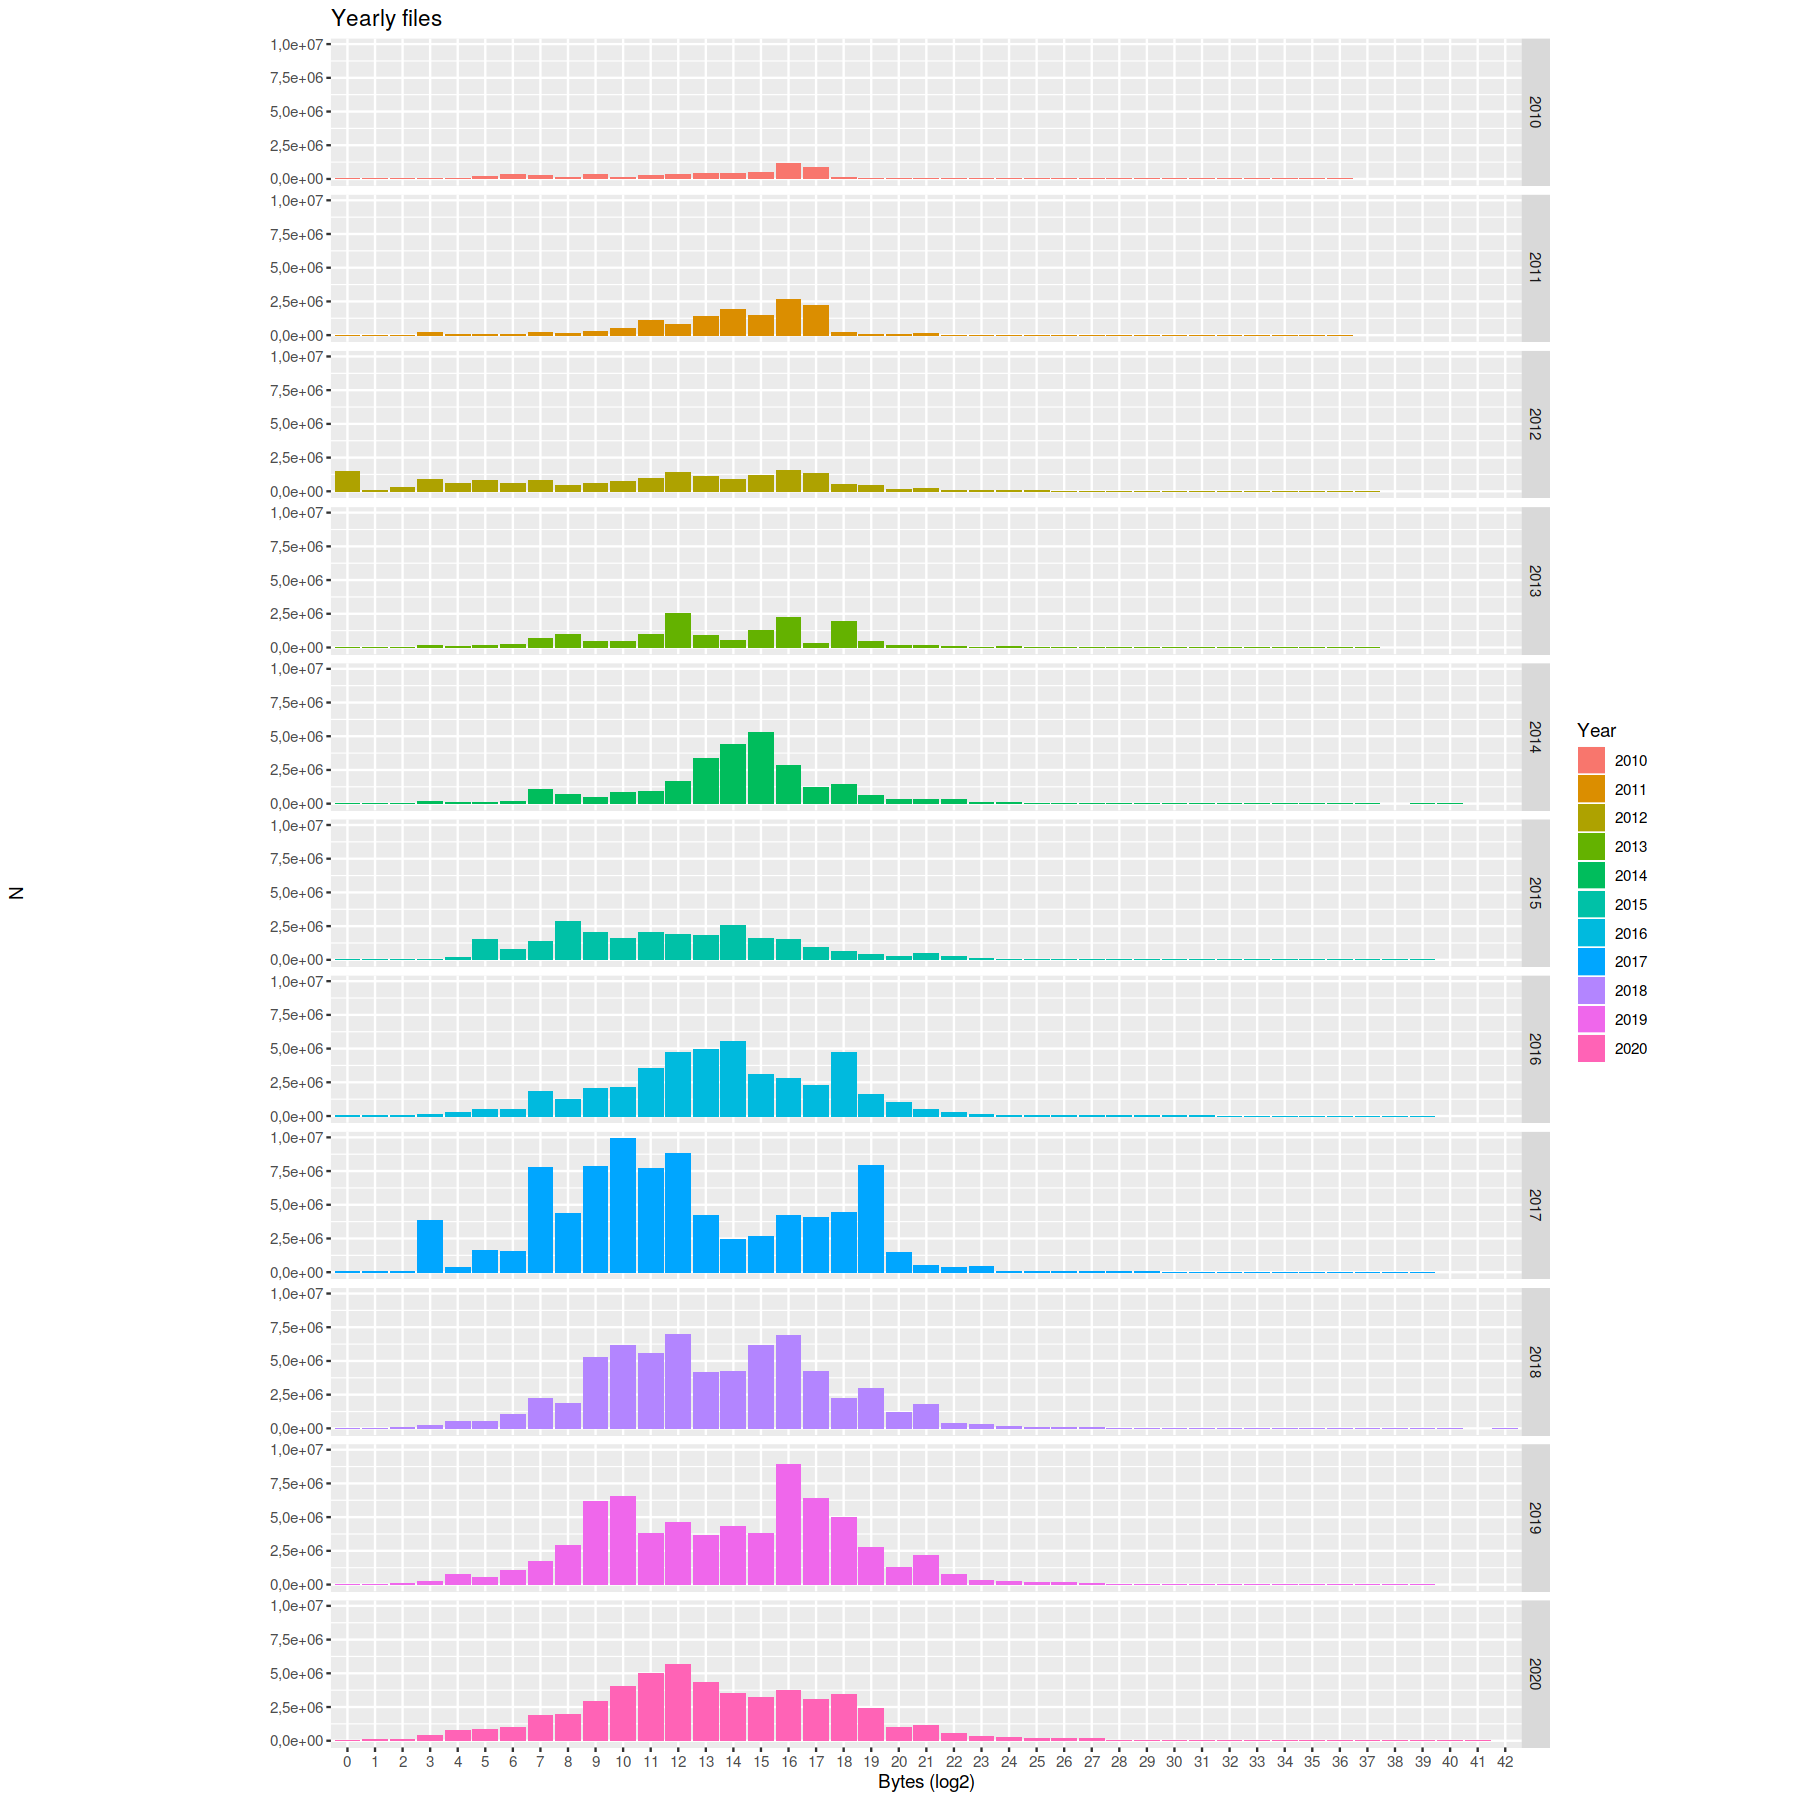

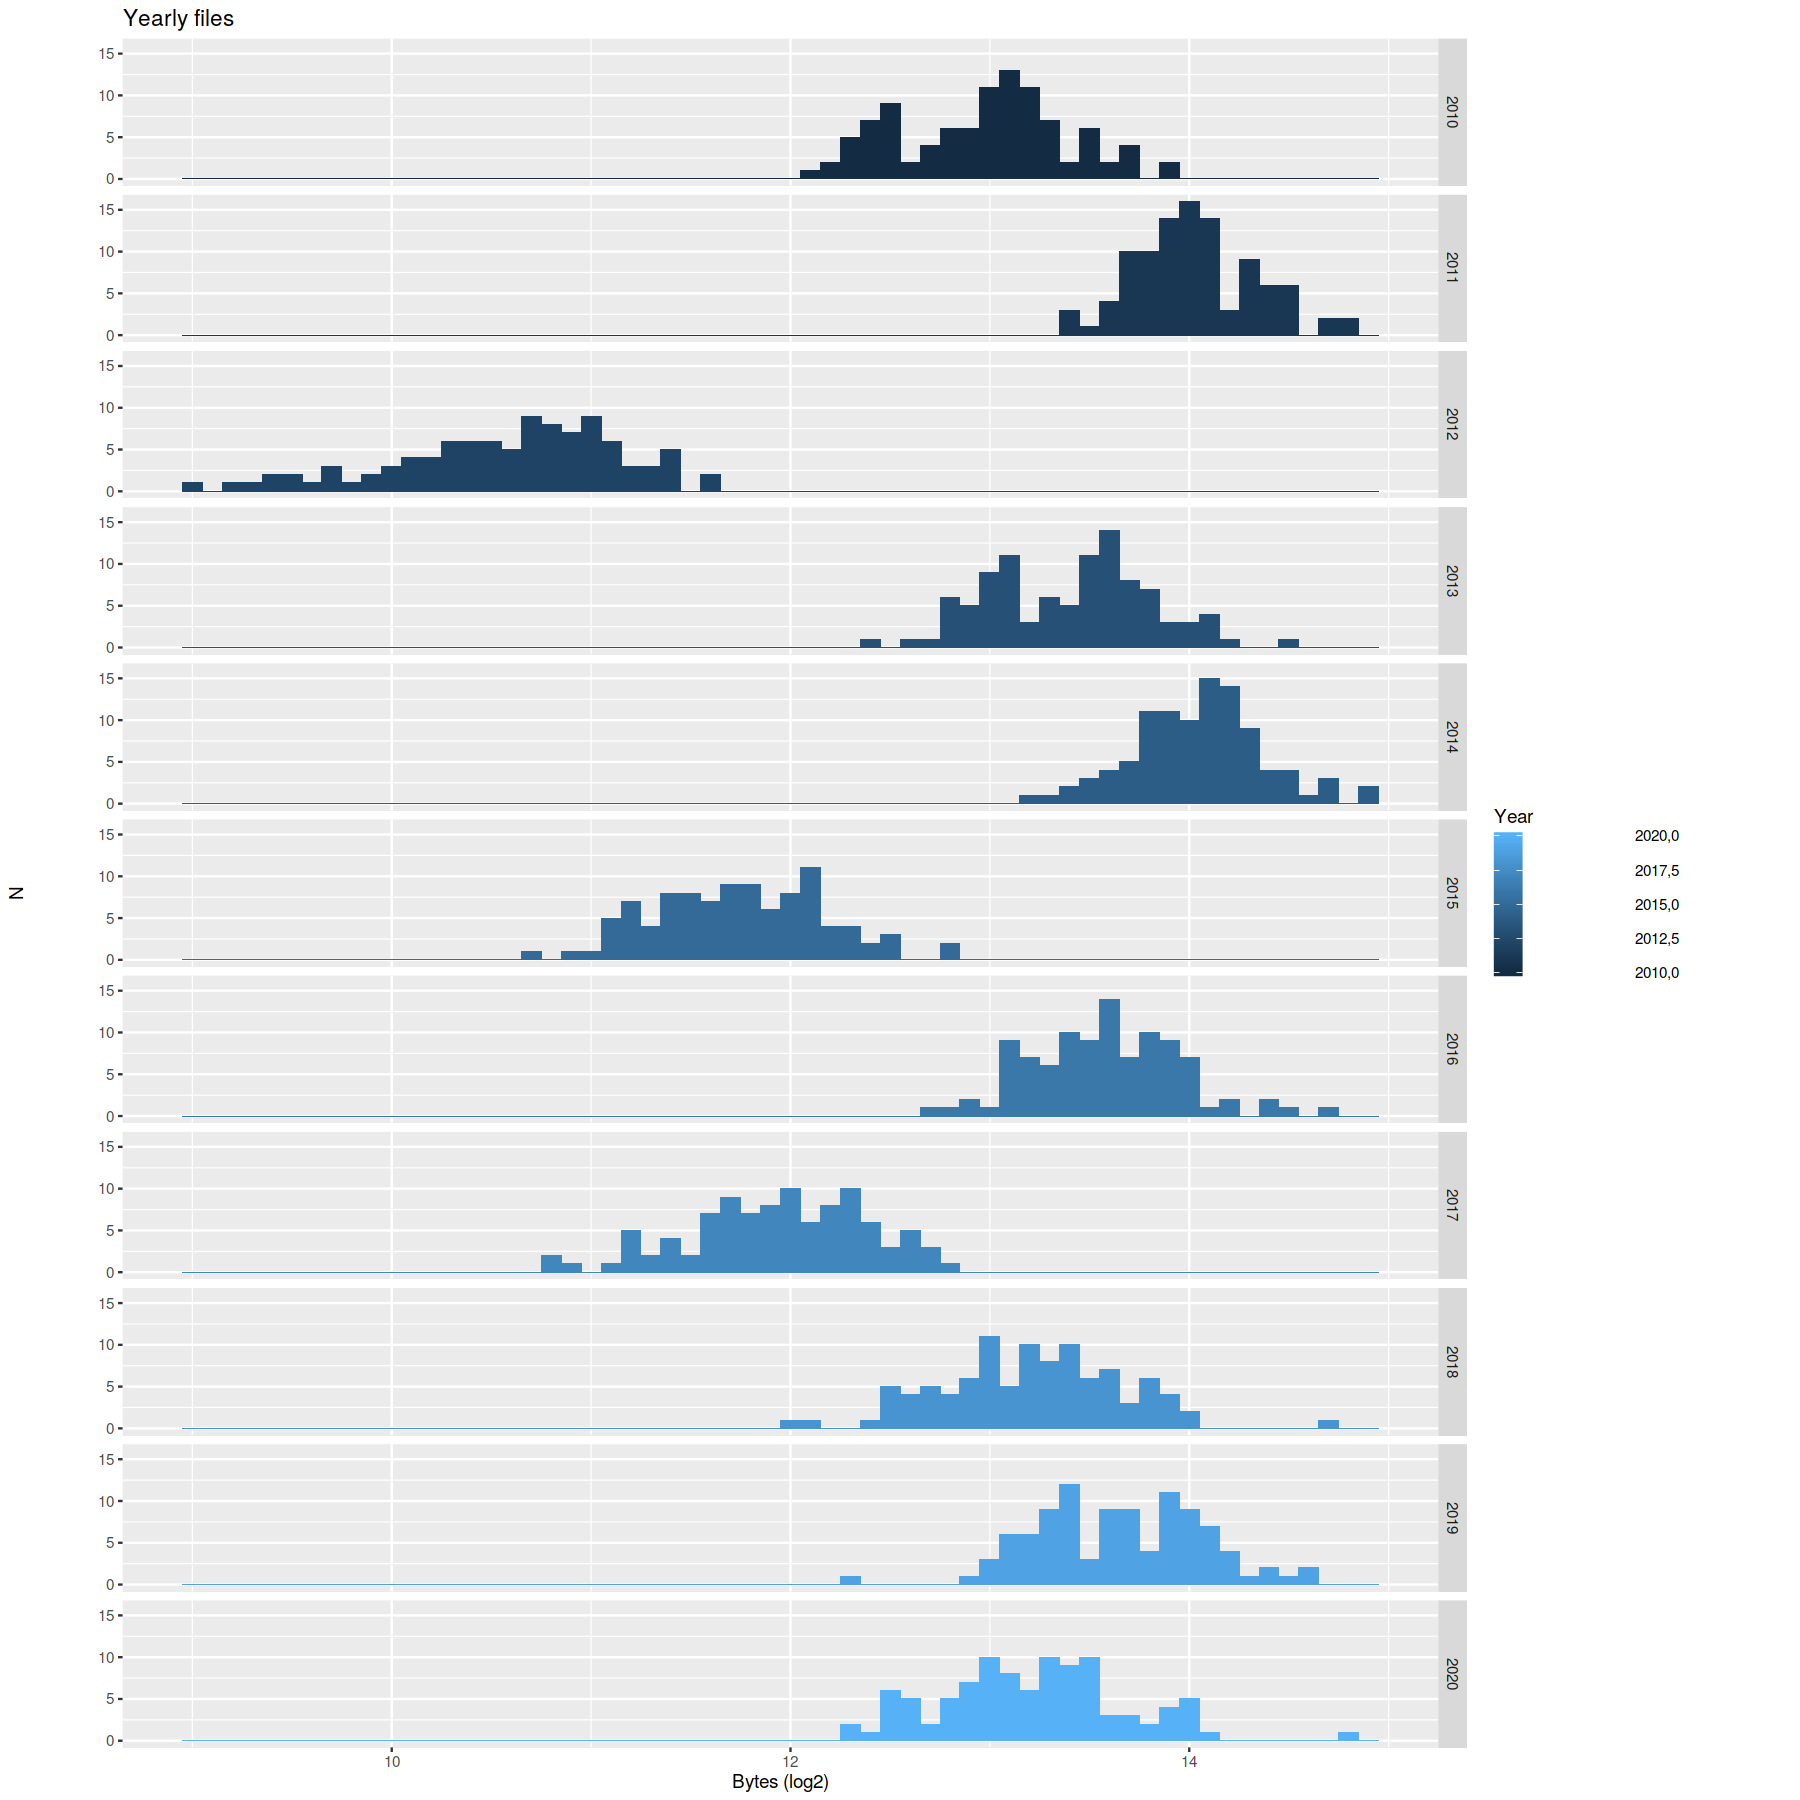

In [266]:
yearly_bytes_sum %>%
    ggplot(aes(x=as.factor(BytesLog2), y=Files, fill=Year)) +
        geom_bar(stat='identity') +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(Year))

bootstrapped_means_distribution %>%
    ggplot(aes(x=SampledMeans, fill=Year)) +
        geom_histogram(binwidth=0.1) +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(Year))

In [255]:
options(repr.plot.width=15, repr.plot.height=15)

for (year in bootstrapped_means[['Year']]) {
    real_data <- yearly_bytes_sum[yearly_bytes_sum['Year']==year,]
    sampled_data <- yearly_bytes_sum[yearly_bytes_sum['Year']==year,]
    ggplot(aes(x=as.factor(yearly_bytes_sum), y=n_total, fill=year)) +
#        geom_bar(stat='identity') +
#        ylab('N') +
#        xlab('Bytes (log2)') +
#        ggtitle('Yearly files') +
#        facet_grid(rows=vars(year))
}

#bootstrapped_means %>%
#    mutate(year=as.factor(year)) %>%
#    ggplot(aes(x=as.factor(yearly_bytes_sum), y=n_total, fill=year)) +
#        geom_bar(stat='identity') +
#        ylab('N') +
#        xlab('Bytes (log2)') +
#        ggtitle('Yearly files') +
#        facet_grid(rows=vars(year))

ERROR: Error in parse(text = x, srcfile = src): <text>:12:1: unexpected '}'
11: #        facet_grid(rows=vars(year))
12: }
    ^


## Fitting functions to data

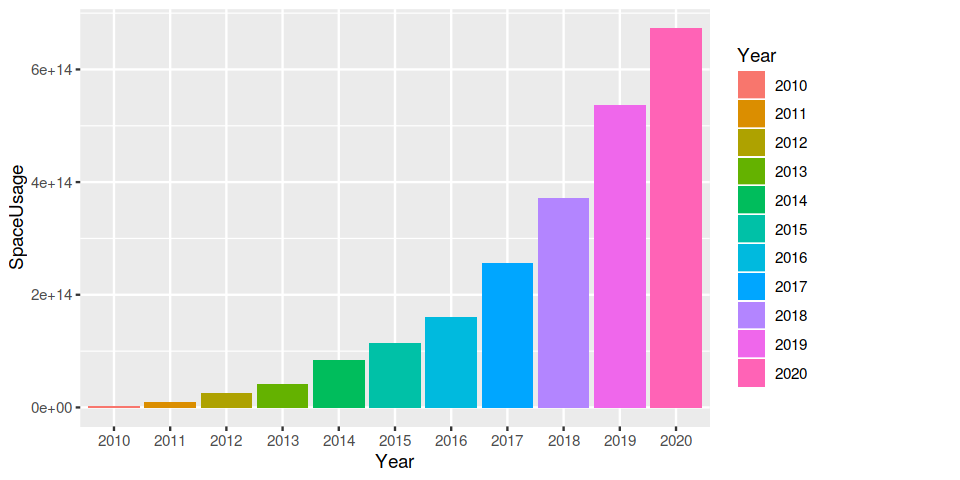

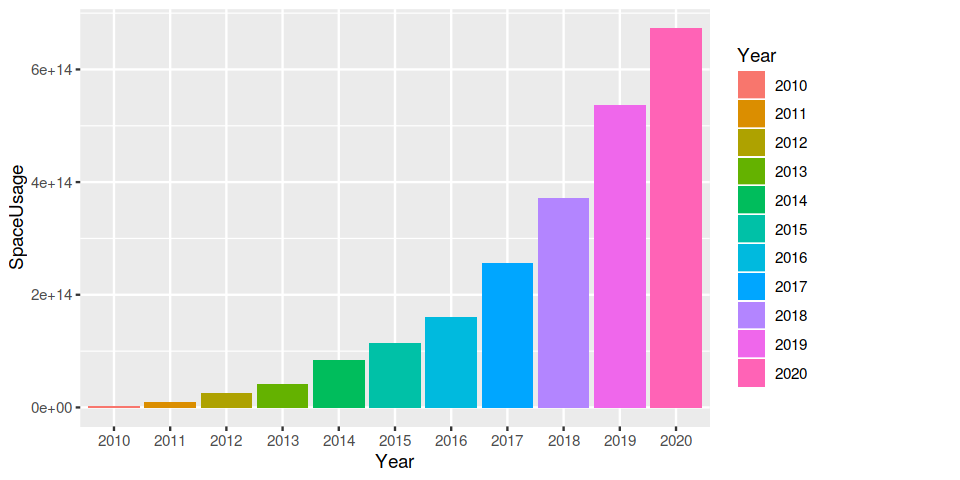

In [122]:
newfiles_yearly_cumsum <- newusage_yearly_sum %>%
    mutate(SpaceUsage=cumsum(SpaceUsage))
newusage_yearly_cumsum <- newusage_yearly_sum %>%
    mutate(SpaceUsage=cumsum(SpaceUsage))

print(newfiles_yearly_cumsum %>%
    ggplot(aes(x=Year, y=SpaceUsage, fill=Year)) +
    geom_col())
print(newusage_yearly_cumsum %>%
    ggplot(aes(x=Year, y=SpaceUsage, fill=Year)) +
    geom_col())

Saving 6,67 x 6,67 in image


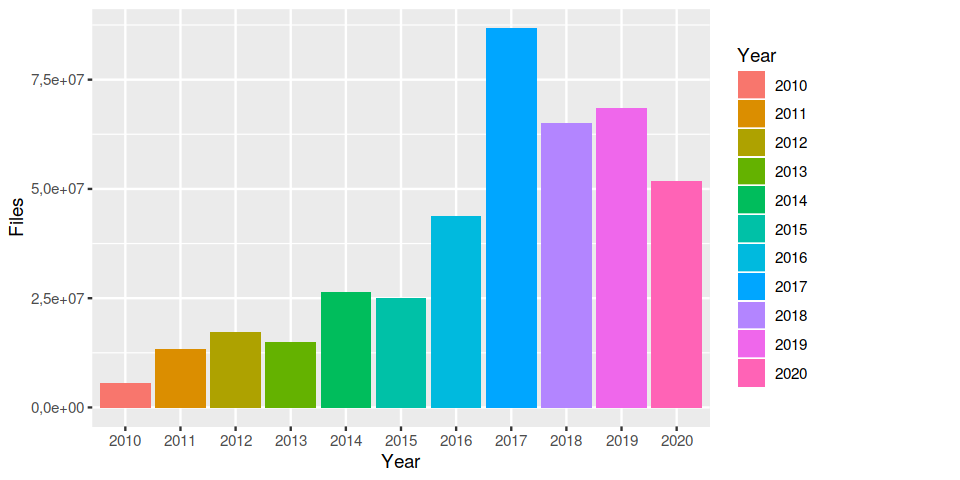

In [14]:
options(repr.plot.width=8, repr.plot.height=4)

newfiles_yearly_plot <-  newfiles_yearly_sum %>%
    mutate(Year=as.factor(Year)) %>%
    ggplot(aes(x=Year, y=Files, fill=Year)) +
    geom_col()

print(newfiles_yearly_plot)

ggsave('newfiles_yearly_sum_r.png')

In [8]:
options(repr.plot.width=12, repr.plot.height=2)

for (year in seq(min(years),max(years))) {
    yearly_data <- filesizes_yearly[filesizes_yearly['year'] == year,] %>%
        mutate(year=as.factor(year))
    print(yearly_data %>%
        ggplot(aes_(~ as.factor(bytes2), ~ n_total, fill=year)) +
            geom_bar(stat='identity', show.legend = FALSE) +
            ylab('N') +
            xlab('Bytes (log2)') +
            ggtitle(year))
}

ERROR: Error in min(years): invalid 'type' (closure) of argument


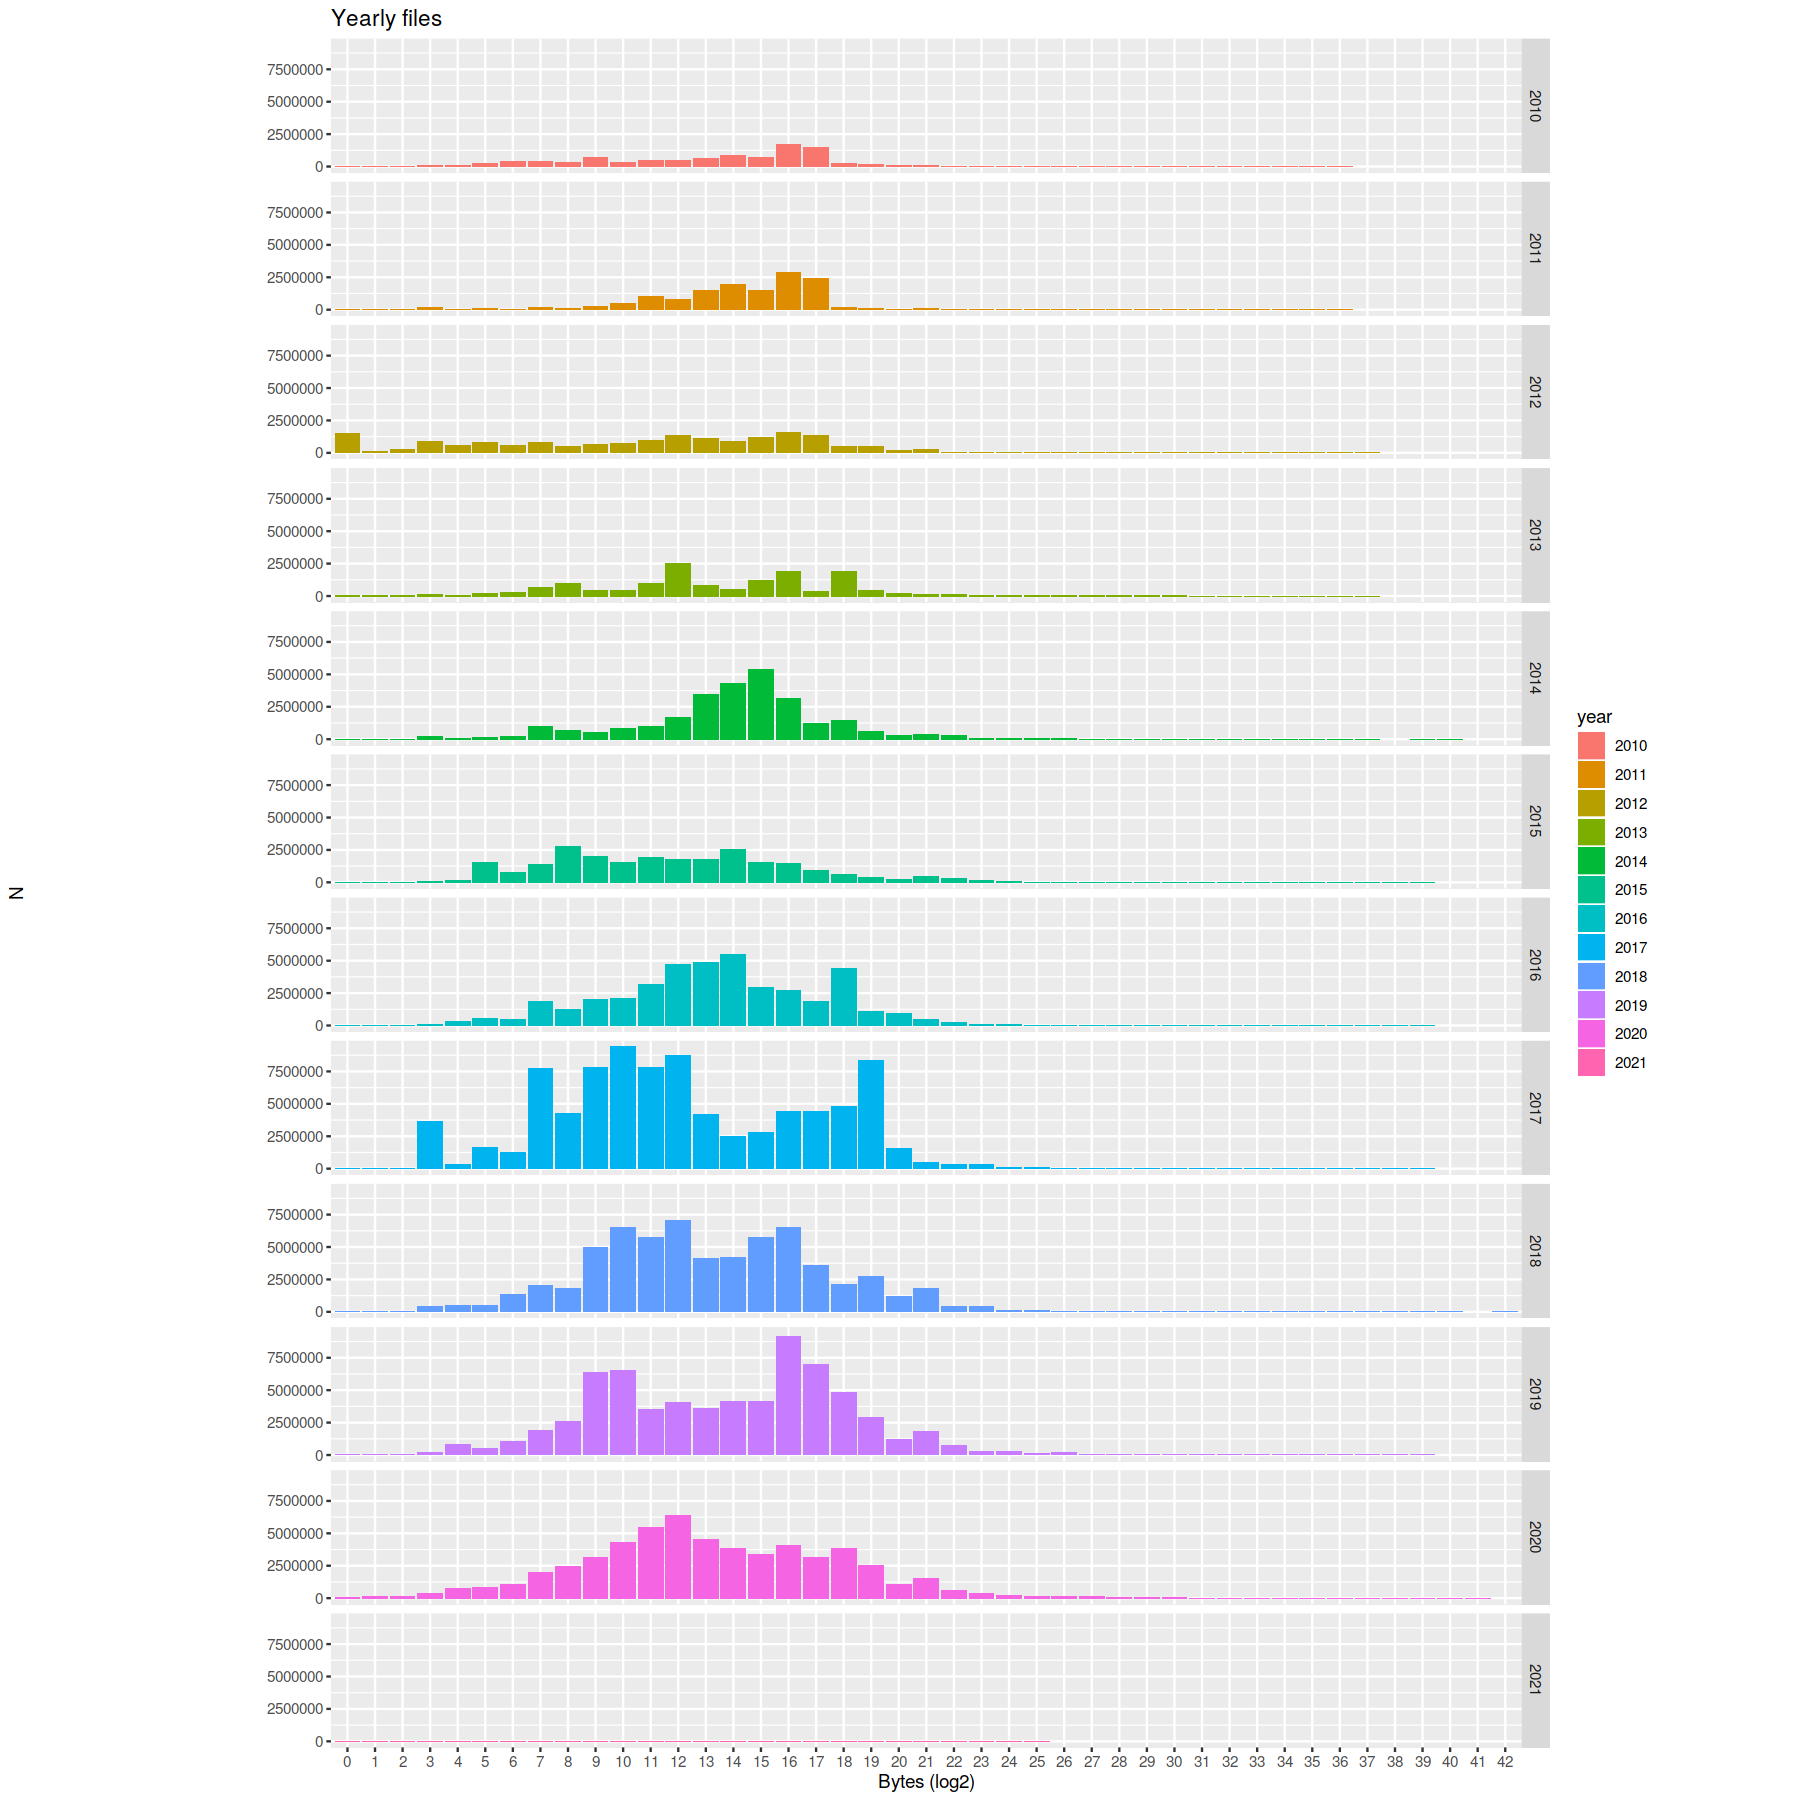

In [90]:
options(repr.plot.width=15, repr.plot.height=15)

filesizes_yearly %>%
    mutate(year=as.factor(year)) %>%
    ggplot(aes(x=as.factor(bytes2), y=n_total, fill=year)) +
        geom_bar(stat='identity') +
        ylab('N') +
        xlab('Bytes (log2)') +
        ggtitle('Yearly files') +
        facet_grid(rows=vars(year))

In [91]:
library(boot)

In [92]:
nsamples <- tibble(sample_number=seq(1000))

In [93]:
filesizes_sampled <- crossing(nsamples, years)

In [94]:
get_bootstrapped_mean <- function(year) {
    yearly_data <- filesizes_yearly %>%
        filter(year==year)
    bytes2 <- yearly_data$bytes2
    n_total <- yearly_data$n_total
    sampled_data <- sample(bytes2, 100, replace=TRUE, prob=n_total)
    return(mean(sampled_data))
}

In [250]:
get_bootstrapped_mean2 <- function(year, n_means=10000) {
    sampled_means <- numeric(n_means)
    years_data <- filesizes_yearly[filesizes_yearly['year'] == year,] %>%
        mutate(year=as.factor(year))
    bytes2 <- years_data$bytes2
    n_total <- years_data$n_total
    for (i in seq(n_means)) {
        sampled_means[[i]] <- sample(bytes2, 100, replace=TRUE, prob=n_total) %>%
            mean()
    }
    return(tibble(sampled_means=sampled_means))
}

In [251]:
get_bootstrapped_mean2(2012) %>%
    summarize(mean=mean(sampled_means))

mean
"10,67666"


In [252]:
get_bootstrapped_mean(2020)

[1] 13,28

In [96]:
time1 = Sys.time()
for (i in seq(10)) {
    filesizes_sampled %>%
        mutate(mean_fs=Vectorize(get_bootstrapped_mean)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

Time difference of 2,202973 secs


In [156]:
time1 = Sys.time()
for (i in seq(10)) {
    years %>%
        mutate(sampled_means=Vectorize(get_bootstrapped_mean2)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

Time difference of 0,9186298 secs


In [253]:
filesizes_sampled <- years %>%
    mutate(sampled_means=map(year, get_bootstrapped_mean2)) %>%
    unnest()

In [254]:
time1 = Sys.time()
for (i in seq(10)) {
    filesizes_sampled %>%
        mutate(mean_fs=Vectorize(get_bootstrapped_mean)(year))
}
time2 = Sys.time()
print((time2-time1)/10)

In [175]:
filesizes_sampled['sampled_means'] <- as.numeric(map(filesizes_sampled$year, get_bootstrapped_mean))

In [255]:
filesizes_sampled %>%
    group_by(year) %>%
    summarize_all(.funs=c(mean))

year,sampled_means
2010,"13,18852"
2011,"14,12835"
2012,"10,66711"
2013,"13,42103"
2014,"14,02680"
2015,"11,72655"
2016,"13,40625"
2017,"12,12566"
2018,"13,13400"
2019,"13,72982"


Warning message:
“Removed 24 rows containing missing values (geom_bar).”

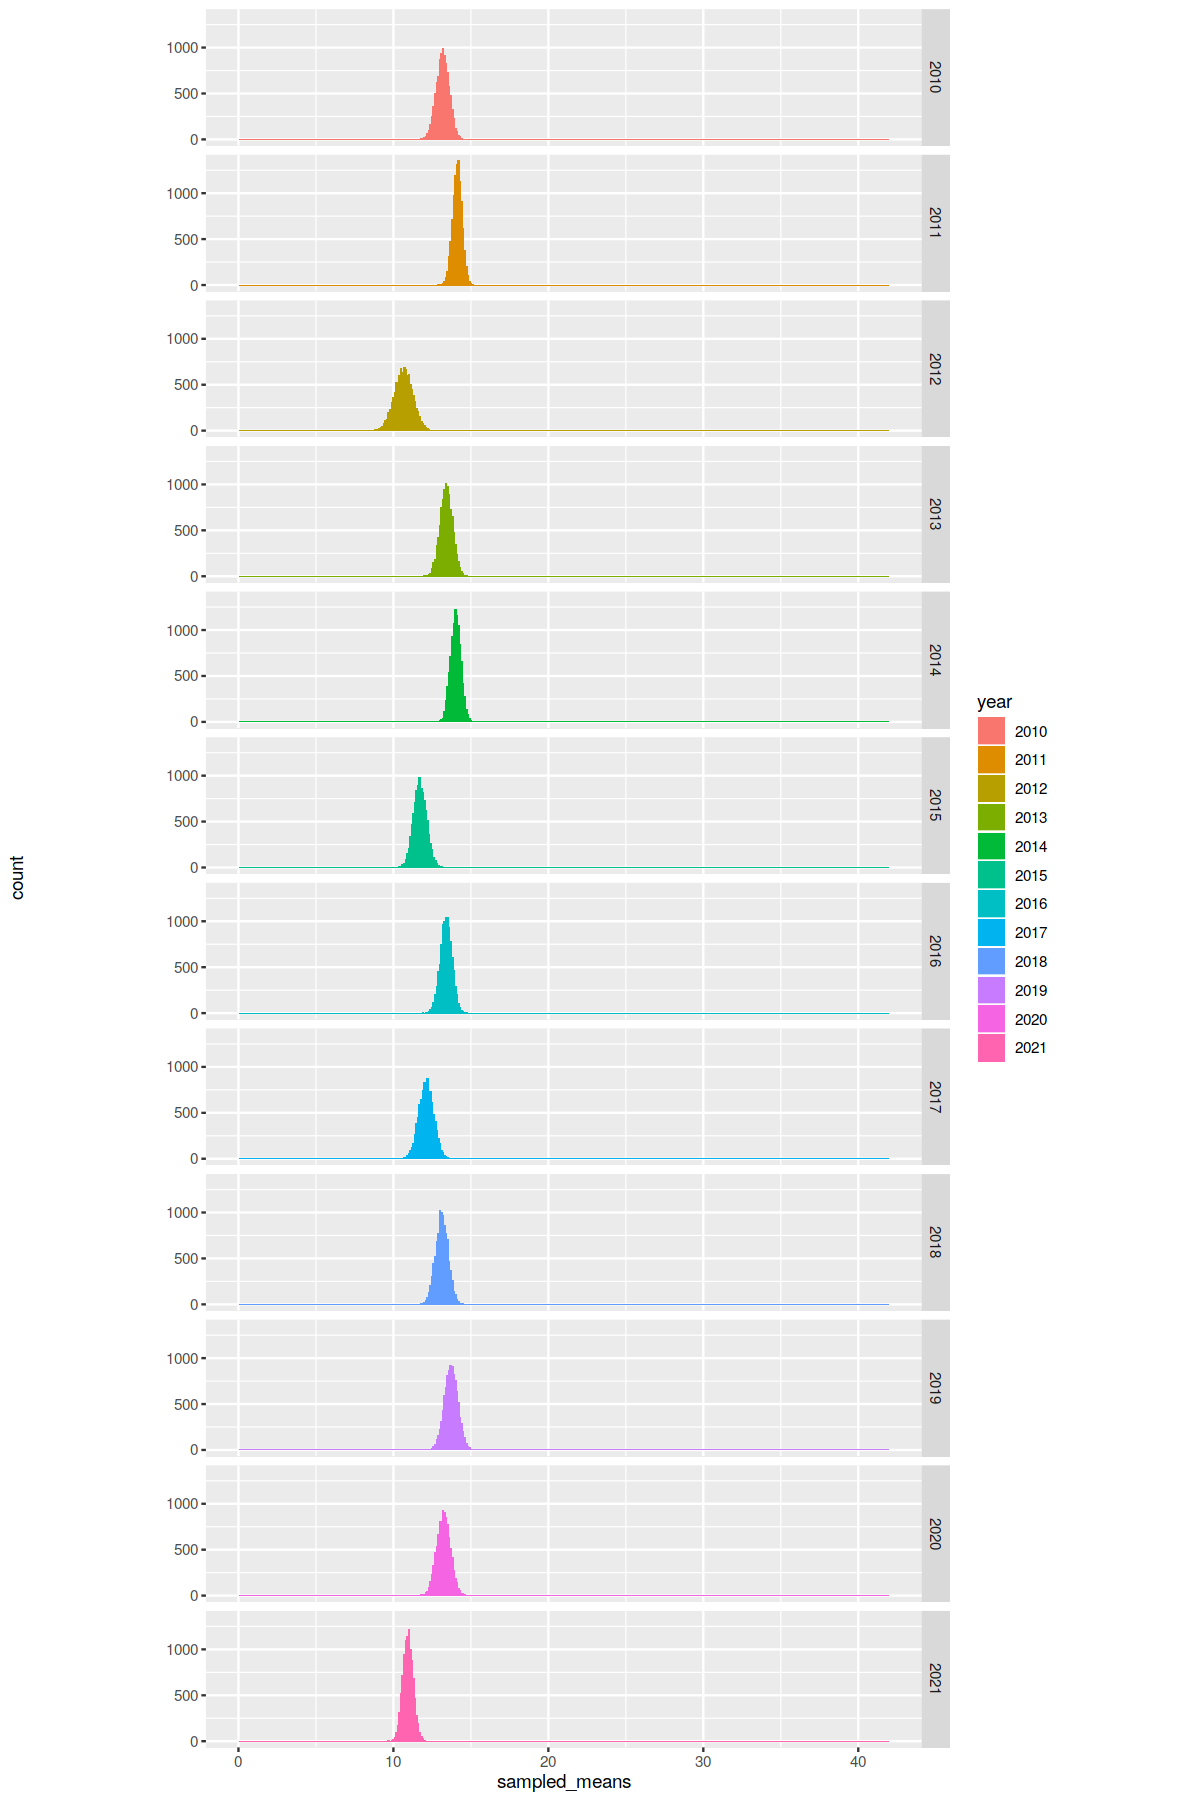

In [256]:
options(repr.plot.width=10, repr.plot.height=15)

filesizes_sampled %>%
    select(year, sampled_means) %>%
    mutate(year=as.factor(year)) %>%
    ggplot(aes(x=sampled_means, fill=year)) +
        geom_histogram(binwidth=0.1) +
        xlim(range(bytes2)) +
#        ylab('N') +
#        xlab('Bytes (log2)') +
#        ggtitle('Yearly files') +
        facet_grid(rows=vars(year))